# Environment Setup and Imports


In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/churn-data/sample_submission.csv
/kaggle/input/churn-data/train.csv
/kaggle/input/churn-data/test.csv


In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
try:
    from sklearn.neighbors import KNeighborsClassifier
    knn_available = True
except ImportError:
    knn_available = False
    print("Warning: KNeighborsClassifier import failed; skipping KNN-based stacking.")

from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

# SHAP for model interpretability
import shap

# Loading the Data

In [4]:
train_df = pd.read_csv('/kaggle/input/churn-data/train.csv')
test_df = pd.read_csv('/kaggle/input/churn-data/test.csv')

df_ss = pd.read_csv("/kaggle/input/churn-data/sample_submission.csv")
df_ss = df_ss.rename(columns={'RowNumber':'id'})


In [5]:
train_df.shape

(165034, 14)

In [6]:
test_df.shape

(110023, 13)

# Checking the data
##### Reviewing the rows, summary stats and the abnormalities in the data like missing values and outliers.

In [7]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [11]:
test_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,1.100230e+05,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,220045.000000,1.569210e+07,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,31761.048671,7.168499e+04,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,165034.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,192539.500000,1.563286e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,220045.000000,1.569018e+07,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,247550.500000,1.575693e+07,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,275056.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


In [12]:
test_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

# Conducting EDA
#### We check for different plots like countplots, histplots ,correlation matrix and many more.


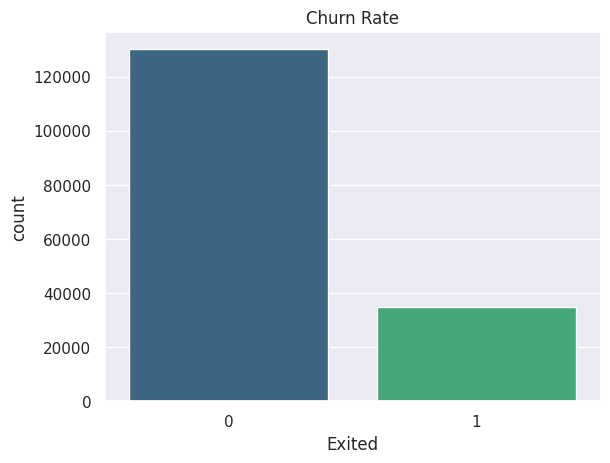

In [13]:
sns.countplot(x='Exited', data=train_df, palette='viridis', hue=None)
plt.title('Churn Rate')
plt.show()



*   
 Plot reveals a class imbalance: approximately 130,000 customers (about 78%) remained (Exited = 0), while roughly 35,000 customers (about 22%) churned (Exited = 1). This suggests that techniques such as **stratified samples or class weights** will be important to train model.






use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


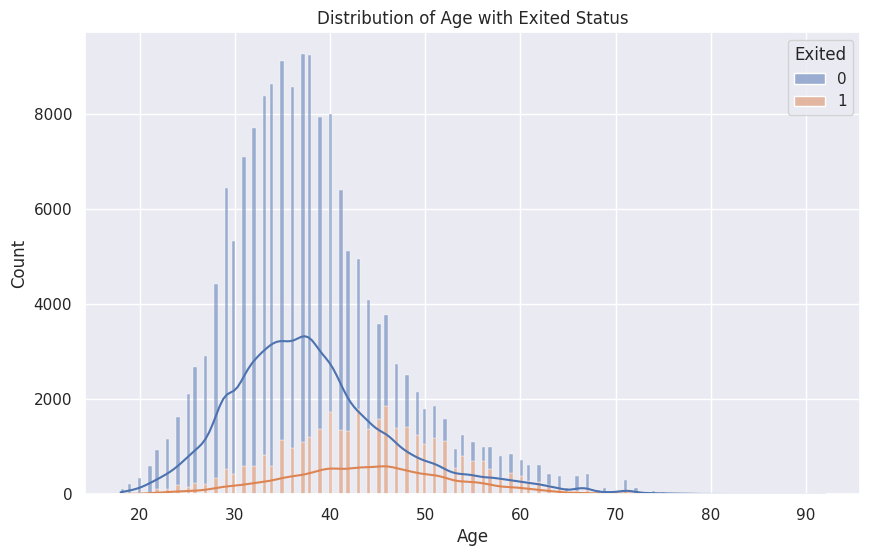

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', hue='Exited', multiple='stack', kde=True)
plt.title('Distribution of Age with Exited Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()




*  Age is a strong feature as it has the specified group of people who are
exiting. E.g. In the above plots we can see that the people in the age group of 25-40 show a strong concentration while the people in the age group of 45-60 are likely to churn(Exit).

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


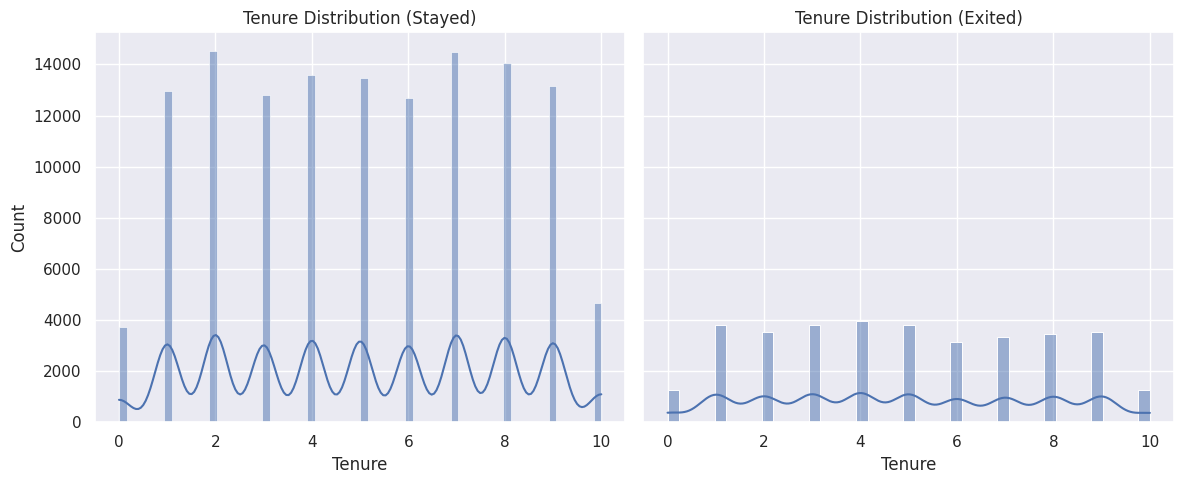

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(data=train_df[train_df['Exited'] == 0], x='Tenure', ax=axes[0], kde=True)
axes[0].set_title('Tenure Distribution (Stayed)')
axes[0].set_xlabel('Tenure')
axes[0].set_ylabel('Count')

sns.histplot(data=train_df[train_df['Exited'] == 1], x='Tenure', ax=axes[1], kde=True)
axes[1].set_title('Tenure Distribution (Exited)')
axes[1].set_xlabel('Tenure')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

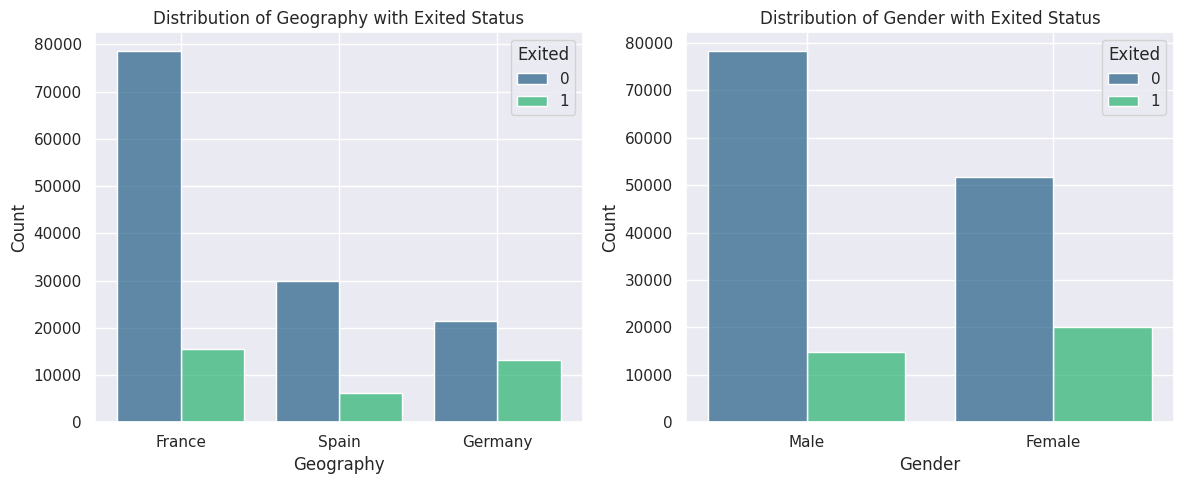

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histplot for Geography
sns.histplot(data=train_df, x='Geography', hue='Exited', multiple='dodge', shrink=0.8, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Geography with Exited Status')
axes[0].set_xlabel('Geography')
axes[0].set_ylabel('Count')

# Histplot for Gender
sns.histplot(data=train_df, x='Gender', hue='Exited', multiple='dodge', shrink=0.8, ax=axes[1], palette='viridis')
axes[1].set_title('Distribution of Gender with Exited Status')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


*   Geography:
 France has the highest number of customers who show retention but also have high churn customers than the other countries whereas Germany has the highest churn rate.
*   Gender:
Female customers have high churn proportions than males.



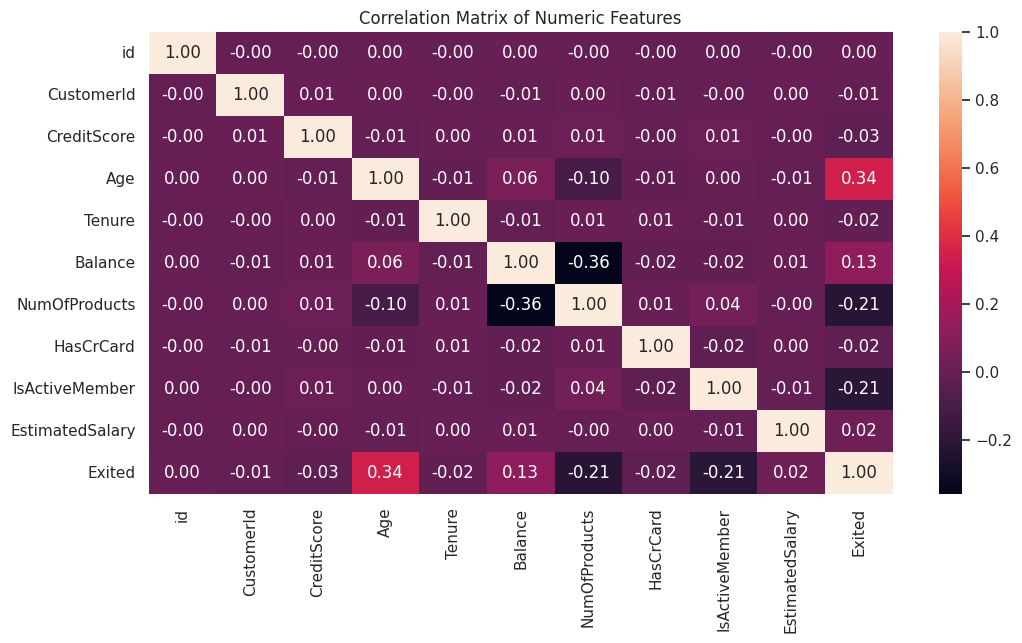

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()



*   Age vs. Exited: Age exhibits the strongest positive correlation (≈0.25) with churn, confirms that older customers are more likely to leave.

*   Balance vs. Exited: Balance shows a small positive correlation (≈0.10), suggests customers with larger balances have a slightly higher churn tendency.
*   NumOfProducts & IsActiveMember vs. Exited: Both features correlate negatively (around ≈−0.15), indicates that customers with more products or who are active members are less prone to churn.


*   CreditScore vs. Exited: A weak negative relationship (≈0−0.05) suggests higher credit scores modestly reduce churn risk.


*   Multicollinearity: Most feature pairs have low inter-correlations (<|0.3|), reduces concerns about redundancy, and unique identifiers (id, CustomerId) show no meaningful relationships, so they can be safely excluded from model.





# Feature Engineering


##### Risking data leakage by computing cohort statistics (like churn rate) using highly granular identifiers such as CustomerId, Surname, or exact Age, which often reproduce a row’s own target and let the model "cheat." To prevent this, we should drop or coarsen high-cardinality features (e.g., bin Age, remove CustomerId), compute group statistics only on the training fold during cross-validation, and apply techniques like smoothing or minimum count thresholds. This ensures the model captures useful cohort patterns while maintaining generalization and avoiding overfitting.

##### 1. IsActive_by_CreditCard = HasCrCard × IsActiveMember Combines two engagement signals into one interaction feature:

##### 2. BalancePerProduct = Balance ÷ NumOfProducts Normalizes total balance by product count to capture average product value and product engagement.
##### 3. Products_Per_Tenure = Tenure ÷ NumOfProducts Measures the rate of product adoption over a customer’s lifespan
##### 4. SeniorCitizen = (Age ≥ 60) Creates a “senior” segment:
##### 5. TenureBucket = pd.cut(Tenure, bins=[–1,2,5,10], labels=[‘low’,‘mid’,‘high’]) Converts continuous tenure into three cohorts
##### 6. AgeCat = round(Age ÷ 20).astype(int).astype('category') Groups age into broad decade-based categories (0–20, 21–40, 41–60, 61+)

In [18]:
for df in [train_df, test_df]:
  df['IsActive_by_CreditCard'] = df['IsActiveMember'] * df['HasCrCard']
  df['BalancePerProduct'] = df['Balance'] / df['NumOfProducts']
  df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts']
  df['SeniorCitizen'] = (df['Age'] >= 60).astype(int)
  df['TenureBucket'] = pd.cut(df['Tenure'], bins=[-1, 2, 5, 10], labels=['low', 'mid', 'high'])
  df['AgeCat'] = (df['Age'] / 20).astype(int).astype('category')

### Handling Categorical Data

In [19]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      165034 non-null  int64   
 1   CustomerId              165034 non-null  int64   
 2   Surname                 165034 non-null  object  
 3   CreditScore             165034 non-null  int64   
 4   Geography               165034 non-null  object  
 5   Gender                  165034 non-null  object  
 6   Age                     165034 non-null  float64 
 7   Tenure                  165034 non-null  int64   
 8   Balance                 165034 non-null  float64 
 9   NumOfProducts           165034 non-null  int64   
 10  HasCrCard               165034 non-null  float64 
 11  IsActiveMember          165034 non-null  float64 
 12  EstimatedSalary         165034 non-null  float64 
 13  Exited                  165034 non-null  int64   
 14  IsAc

In [20]:
train_df = pd.get_dummies(data=train_df, columns=['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'TenureBucket', 'AgeCat'], drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'TenureBucket', 'AgeCat'], drop_first=True)

In [21]:
train_df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'EstimatedSalary', 'Exited', 'IsActive_by_CreditCard',
       'BalancePerProduct', 'Products_Per_Tenure', 'SeniorCitizen',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
       'HasCrCard_1.0', 'IsActiveMember_1.0', 'TenureBucket_mid',
       'TenureBucket_high', 'AgeCat_1', 'AgeCat_2', 'AgeCat_3', 'AgeCat_4'],
      dtype='object')

### Min-Max feature Scaling
##### Min–Max scaling ensures the features are on a level playing field for most machine‑learning algorithms that depend on distance measures (e.g., KNN) or gradient-based optimization.. Min–Max scaling rescales a numeric feature to a fixed range; usually [0, 1], according to below formula: xscaled=x−min⁡(x)max⁡(x)−min⁡(x). xscaled​=max(x)−min(x)x−min(x)​.

We fit scaler only on train and apply to test.

In [22]:
scale_cols = ['Age','CreditScore','Balance','EstimatedSalary']
scaler = MinMaxScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df [scale_cols] = scaler.transform(test_df [scale_cols])

# Model Selection


In [23]:
# Applying stratified K-fold due to imbalance in data
NUM_FOLDS_CB    = 9
N_EST        = 500
SEED        = 42
kf = StratifiedKFold(n_splits=NUM_FOLDS_CB, random_state=SEED, shuffle=True)

In [24]:
target = 'Exited'
ignore_cols = ['RowNumber','CustomerId','Surname']
features = [c for c in train_df.columns if c not in ignore_cols + [target]]

X = train_df[features]
y = train_df[target]
X_test = test_df[features]

In [25]:
X.head()

,id,CreditScore,Age,Tenure,Balance,EstimatedSalary,IsActive_by_CreditCard,BalancePerProduct,Products_Per_Tenure,SeniorCitizen,...,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,TenureBucket_mid,TenureBucket_high,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4
0,0,0.636,0.202703,3,0.000000,0.907279,0.0,0.00,1.5,0,...,False,False,True,False,True,False,True,False,False,False
1,1,0.554,0.202703,1,0.000000,0.247483,1.0,0.00,0.5,0,...,False,False,True,True,False,False,True,False,False,False
2,2,0.656,0.297297,10,0.000000,0.924364,0.0,0.00,5.0,0,...,False,False,True,False,False,True,False,True,False,False
3,3,0.462,0.216216,2,0.593398,0.422787,1.0,148882.54,2.0,0,...,False,False,True,True,False,False,True,False,False,False
4,4,0.732,0.202703,5,0.000000,0.075293,1.0,0.00,2.5,0,...,False,False,True,True,True,False,True,False,False,False


In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64

In [27]:
X_test.head()

,id,CreditScore,Age,Tenure,Balance,EstimatedSalary,IsActive_by_CreditCard,BalancePerProduct,Products_Per_Tenure,SeniorCitizen,...,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,TenureBucket_mid,TenureBucket_high,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4
0,165034,0.472,0.067568,2,0.000000,0.804903,0.0,0.00,1.0,0,...,False,False,False,True,False,False,True,False,False,False
1,165035,0.666,0.378378,2,0.000000,0.362723,0.0,0.00,2.0,0,...,False,False,True,False,False,False,False,True,False,False
2,165036,0.612,0.216216,7,0.000000,0.694419,0.0,0.00,3.5,0,...,False,False,True,False,False,True,True,False,False,False
3,165037,0.662,0.243243,8,0.000000,0.569654,0.0,0.00,8.0,0,...,False,False,True,False,False,True,True,False,False,False
4,165038,0.804,0.270270,10,0.483318,0.697164,0.0,121263.62,10.0,0,...,False,False,True,False,False,True,True,False,False,False


In [28]:
# Identify categorical feature indices for CatBoost
cat_features = np.where(X.dtypes != np.float64)[0]

In [29]:
%%time
models = {
    'LogisticRegression': LogisticRegression(max_iter=N_EST, random_state=SEED),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=N_EST, random_state=SEED),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=N_EST, random_state=SEED),
    'LightGBM': LGBMClassifier(n_estimators=N_EST, learning_rate=0.02, random_state=SEED, verbose=-1 ),
    'CatBoost': CatBoostClassifier(iterations=N_EST, learning_rate=0.02, verbose=0, random_state=SEED),
    # 'VotingEnsemble': VotingClassifier(estimators=[
    #     ('lr', LogisticRegression(max_iter=N_EST, random_state=SEED)),
    #     ('knn_unif', KNeighborsClassifier(n_neighbors=5, weights='uniform')),
    #     ('knn_dist', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    #     ('rf_gini', RandomForestClassifier(n_estimators=N_EST, criterion='entropy', random_state=SEED)),
    #     ('rf_entr', RandomForestClassifier(n_estimators=N_EST, criterion='gini', random_state=SEED)),
    #     ('et', ExtraTreesClassifier(n_estimators=N_EST, random_state=SEED)),
    #     ('lgbm', LGBMClassifier(n_estimators=N_EST, learning_rate=0.02, random_state=SEED, verbose=-1 )),
    #     ('cb', CatBoostClassifier(iterations=N_EST, learning_rate=0.02, verbose=0, random_state=SEED)),
    #     ('et_gini', ExtraTreesClassifier(n_estimators=N_EST, criterion='gini', random_state=SEED))
    #     ], voting='soft')
}
# cross-validate and collect AUC scores

results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
    results.append({'Model': name, 'Mean_AUC': np.mean(scores), 'Std_AUC': np.std(scores)})
    print(name)

results_df = pd.DataFrame(results).sort_values('Mean_AUC', ascending=False)

LogisticRegression
KNN
RandomForest
ExtraTrees
LightGBM
CatBoost
CPU times: user 48min 24s, sys: 1min 4s, total: 49min 29s
Wall time: 42min 40s


,Model,Mean_AUC,Std_AUC
4,LightGBM,0.889489,0.002794
5,CatBoost,0.888965,0.002687
2,RandomForest,0.877619,0.003096
3,ExtraTrees,0.870010,0.003241
1,KNN,0.556387,0.003631
0,LogisticRegression,0.500699,0.005250


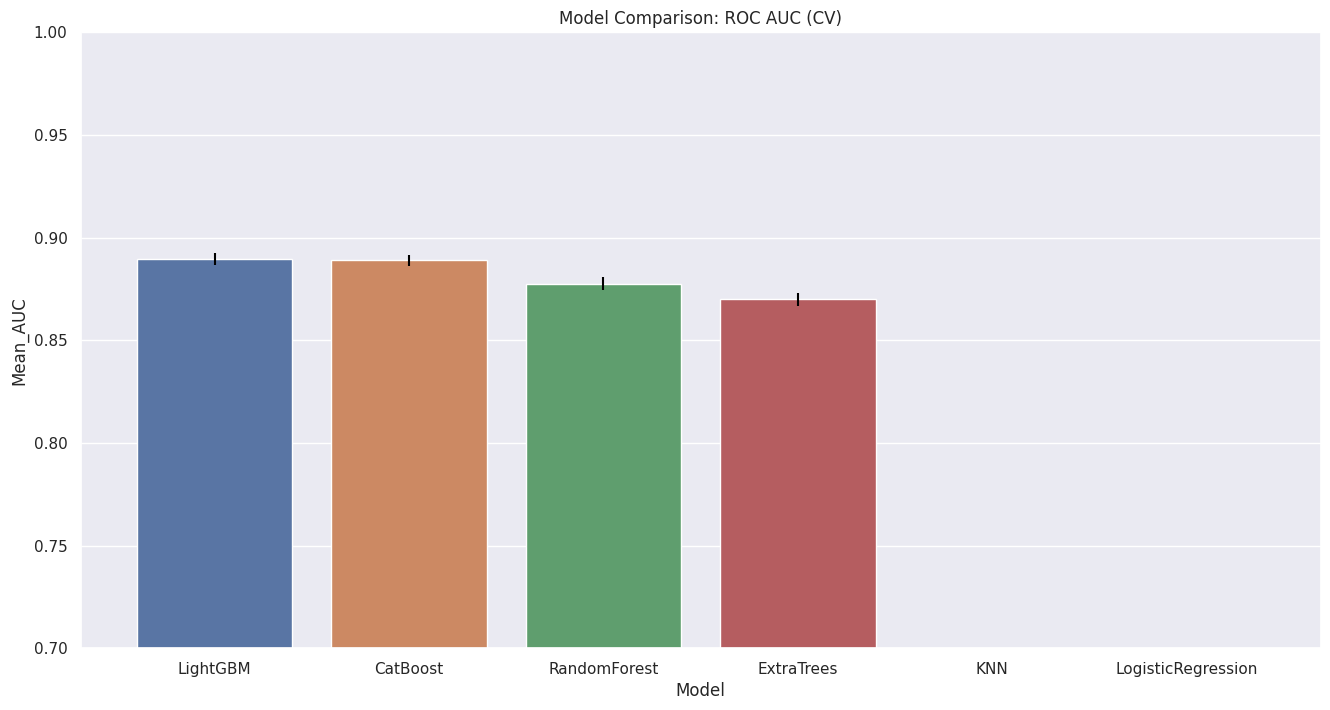

CPU times: user 242 ms, sys: 11 ms, total: 253 ms
Wall time: 247 ms


In [30]:
%%time
display(results_df)

plt.figure(figsize=(16,8))
sns.barplot(x='Model', y='Mean_AUC', data=results_df)
plt.errorbar(x=np.arange(len(results_df)), y=results_df['Mean_AUC'],
             yerr=results_df['Std_AUC'], fmt='none', c='black')
plt.title('Model Comparison: ROC AUC (CV)')
plt.ylim(0.7, 1.0)
plt.show()

* Top Performers are gradient-boosting: CatBoost and LightGBM have the highest mean ROC AUC (≈0.89), indicates strong predictive power.
* Ensembling Benefit: The VotingEnsemble follows closely, combines models to slightly boost stability and performance.
* Tree-Based Models: RandomForest and ExtraTrees deliver solid results (≈0.88 and ≈0.87), though slightly behind the gradient-boosted methods.
* Linear and Non-Parametric: Logistic Regression underperforms (≈0.5), highlights the need for non-linear algorithms on this dataset, and KNN shows slight improvement over random guess.
* Stability: Small error bars for top models indicate consistent performance across folds, suggests reliable generalization.

In [ ]:
%%time
base_learners = [
    ('lgbm', LGBMClassifier(n_estimators=N_EST, learning_rate=0.02, random_state=SEED)),
    ('cb', CatBoostClassifier(iterations=N_EST, learning_rate=0.02, verbose=0, random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=N_EST, random_state=SEED))
]
# Create stacking classifier
stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=N_EST),
    cv=kf,
    stack_method='predict_proba'
)

# Cross-validate stacking performance

stack_scores = cross_val_score(stack_clf, X, y, cv=kf, scoring='roc_auc')
print(f"Stacking CV ROC AUC: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")

# Fit stacking on the full training data before prediction
stack_clf.fit(X, y)

# Predict probabilities on the test set
stack_test = stack_clf.predict_proba(X_test)[:, 1]

# ROC Curves

In [ ]:
%%time
# plot ROC for each model including stacking
plt.figure(figsize=(16,16))
# Combine base models with stacking results
all_models = models.copy()
all_models['Stacking'] = stack_clf

for name, model in all_models.items():
    # Get out‑of‑fold predictions for ROC
    oof_preds = cross_val_predict(model, X, y, cv=kf, method='predict_proba')[:,1]
    fpr, tpr, _ = roc_curve(y, oof_preds)
    auc_score = roc_auc_score(y, oof_preds)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models (Including Stacking)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
%%time
# 9.1 Train CatBoost on full dataset
cb_model = CatBoostClassifier(
    iterations=N_EST,
    learning_rate=0.02,
    verbose=100,
    random_state=SEED
)
cb_model.fit(X, y)
cb_preds = cb_model.predict_proba(X_test)[:, 1]

# 9.2 Train LightGBM on full dataset
lgb_model = LGBMClassifier(
    n_estimators=N_EST,
    learning_rate=0.02,
    random_state=SEED,
    verbose=-1 
)
lgb_model.fit(X, y)
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]

In [ ]:
%%time
# Use existing stacking predictions (stack_test) from Section 7.1
# Blend predictions: 10% CatBoost, 10% LightGBM, 80% Stacking
final_blend = (cb_preds * 0.1) + (lgb_preds * 0.1) + (stack_test * 0.8)

# Create and save the final submission
submission_stack = pd.DataFrame({'id': df_test['id'], 'Exited': final_blend})
submission_stack.to_csv('submission.csv', index=False)
print("Created submission_stacked.csv with stacking-enhanced blend")

In [ ]:
%%time
# 10.1 SHAP Analysis on training data
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X)

# 10.2 SHAP summary plot
shap.summary_plot(shap_values, X, show=False)
plt.title('SHAP Summary: Feature Impact on Churn'); plt.show()

# 10.3 Numeric ranking of drivers
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)
print("Top 10 churn drivers by SHAP importance:\n", shap_importance.head(10))